In [1]:
#Get the class from github (if run from colab):
!wget https://raw.githubusercontent.com/R00cKey/pytorch-DL-class-trainer/main/BaseDLFramework.py

--2025-09-12 14:05:56--  https://raw.githubusercontent.com/R00cKey/pytorch-DL-class-trainer/main/BaseDLFramework.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4487 (4,4K) [text/plain]
Saving to: ‘BaseDLFramework.py.3’

BaseDLFramework.py. 100%[===================>]   4,38K  --.-KB/s    in 0s      

2025-09-12 14:05:57 (20,6 MB/s) - ‘BaseDLFramework.py.3’ saved [4487/4487]



In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
#Create the dataloaders from the IRIS dataset
iris = load_iris()
x = iris.data        # features (150 samples, 4 features each)
y = iris.target      # labels (0, 1, 2)

# Train-test split
X, X_test, Y, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size =0.25, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)

train_loader= DataLoader(TensorDataset(X_train, torch.tensor(Y_train)), batch_size=16, shuffle=True)
val_loader= DataLoader(TensorDataset(X_val, torch.tensor(Y_val)), batch_size=16, shuffle=False)
test_loader= DataLoader(TensorDataset(X_test, torch.tensor(Y_test)), batch_size=16, shuffle=False)

In [4]:
# Create a Deep Learning model
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim : int , hidden_dims: list, output_dim: int):
        super().__init__()

        layers=[]
        prev_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h

        layers.append(nn.Linear(prev_dim, output_dim))
        print(*layers)
        self.fc = nn.Sequential(*layers)

    def forward(self, input):
        return self.fc(input)

In [5]:
from BaseDLFramework import BaseDLFramework
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

class MLPTrainer(BaseDLFramework):
    def __init__(
        self,
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        val_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.modules.loss._Loss,
        snapshot_path: str = "snapshot/snapshot.pt", #Path and filename
        model_init_path: str = 'None',
        best_model_save_path: str='best_model.pt'
        ) -> None:

        #Call the variables from the parent class BaseDLFramework
        super().__init__(model, train_dataloader, optimizer, criterion,
                         snapshot_path, model_init_path, best_model_save_path)

        #Adding the new variables
        self.val_data=val_dataloader
        self._best_val_acc=0
        self._val_acc_by_epochs=[]

        
    def _save_snapshot(self, epoch): ##Backup the training in case of DDP errors, so training can be resumed instead of a reset
        snapshot = {
          "MODEL_STATE": self._model.state_dict(),
          "EPOCHS_RUN": epoch,
          "TRAIN_LOSS_EPOCHS": self._train_loss_by_epochs
        }
        if not os.path.exists(os.path.abspath(os.path.dirname(self._snapshot_path))):
            os.mkdir(os.path.abspath(os.path.dirname(self._snapshot_path)))
        torch.save(snapshot, self._snapshot_path)
        print(f"Epoch {epoch+1} | Training snapshot saved at {self._snapshot_path}")

    #Modify best model dictionary to store best validation set loss
    def _save_best_model(self): #Save the model which performed the best
        best_model={
            "MODEL_STATE": self._model.state_dict(),
            "MODEL_ARCH": str(self._get_model),
            "BEST_ACC": self._best_val_acc,
            "OPTIM_HYPERPARM": self._get_optim_hp()
          }
        torch.save(best_model, self._best_model_save_path)

    #Add validation loop and include it into the epoch run

    def _validation(self):
        correct_pred=0
        total_pred=0

        for x, y in self.val_data:
            x, y =x.to(self._device), y.to(self._device)
            logits = self._model(x)
            predicted_classes = torch.argmax(logits, dim=1)
            correct_pred += (predicted_classes == y).sum().item()
            total_pred += y.size(0)

        val_acc = correct_pred/total_pred
        self._val_acc_by_epochs.append(val_acc)

        return val_acc

    #epochs loop must be updated to include validatoin
    def run_epoch(self, max_epochs: int):
        for epoch in range(self._epochs_run, max_epochs):
            self._model.train()
            train_loss=self._train()
            if train_loss < self._best_train_loss and self._epochs_run+1 >5:
                self._best_train_loss=train_loss

            self._model.eval()
            with torch.no_grad():
                val_acc=self._validation()
                if val_acc > self._best_val_acc and self._epochs_run+1 >5:
                    self._best_val_acc=val_acc
                    print(f"Saving best model at Epoch {self._epochs_run+1}, with Validation Accuracy: {val_acc}")
                    self._save_best_model()

            self._epochs_run+=1
            if epoch % 5 ==0: self._save_snapshot(epoch)

    #Include test method to get test score
    def eval_accuracy(self, test_data: torch.utils.data.DataLoader):
        self._model.load_state_dict(torch.load(self._best_model_save_path)["MODEL_STATE"]) # Load the best-performing model
        correct_pred=0
        total_pred=0
        self._model.to('cpu')
        self._model.eval()
        for x, y in test_data:
            x, y =x.to('cpu'), y.to('cpu')
            logits = self._model(x)
            predicted_classes = torch.argmax(logits, dim=1)
            correct_pred += (predicted_classes == y).sum().item()
            total_pred += y.size(0)

        test_acc = correct_pred/total_pred
        self._model.to(self._device)
        return test_acc

    #Plot the validation accuracy by epochs
    def plot_val_acc_by_epochs(self, title=None, xlabel=None, ylabel=None, label=None, color=None, filename='Val_acc.png'):
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, len(self._val_acc_by_epochs)+1), self._val_acc_by_epochs, label=label, color=color)
        if title:
            ax.set_title(title)
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if label:
            ax.legend()
        print(f"Saving Validation Accuracy Plot at {os.path.abspath(filename)}")
        fig.savefig(filename)


    def plot_confusion_matrix(self, test_dataloader, title="Confusion Matrix", class_names=None, colormap=plt.cm.Blues, filename='Confusion_matrix.png'):
        self._model.load_state_dict(torch.load(self._best_model_save_path)["MODEL_STATE"])  #Load the best-performing model
        self._model = self._model.to('cpu')
        self._model.eval()  # make sure to call self._model

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to('cpu'), labels.to('cpu')
                outputs = self._model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds, labels=np.unique(all_labels))
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fig, ax = plt.subplots()
        cax = ax.matshow(cm, cmap=colormap)
        fig.colorbar(cax)

        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)

        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(title)

        # Annotate each cell with the numeric value
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                text = f"{cm[i, j]:.2f}"
                ax.text(j, i, text, ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
        print(f"Saving Confusion Matrix at {os.path.abspath(filename)}")
        fig.savefig(filename)

In [6]:
model=MLP(4,[16,32,16],3)
trainer=MLPTrainer(model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3),
        criterion=nn.CrossEntropyLoss())

Linear(in_features=4, out_features=16, bias=True) ReLU() Linear(in_features=16, out_features=32, bias=True) ReLU() Linear(in_features=32, out_features=16, bias=True) ReLU() Linear(in_features=16, out_features=3, bias=True)
Loading snapshot
Resuming training from snapshot saved at Epoch 45


In [7]:
#Model Training
trainer.run_epoch(50)

Saving best model at Epoch 46, with Validation Accuracy: 0.9333333333333333
Epoch 46 | Training snapshot saved at snapshot/snapshot.pt


Saving Train Loss Plot at /home/roockey/Desktop/pytorch-DL-class-trainer/test_loss.png
Saving Validation Accuracy Plot at /home/roockey/Desktop/pytorch-DL-class-trainer/Val_acc.png


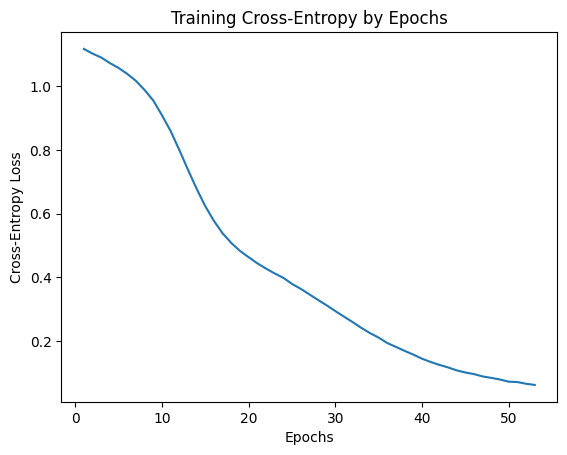

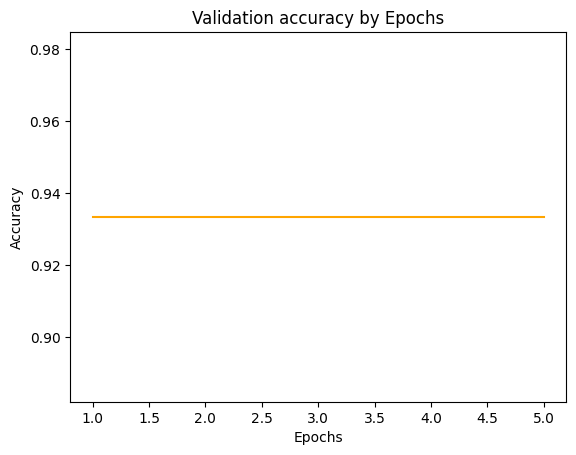

In [8]:
#Plot training loss and validation accuracy
#Note: since the _save_snapshot method has not been modified, the validation accuracy by epochs is not stored
trainer.plot_train_loss_by_epochs(title="Training Cross-Entropy by Epochs", xlabel="Epochs", ylabel="Cross-Entropy Loss")
trainer.plot_val_acc_by_epochs(title="Validation accuracy by Epochs", xlabel="Epochs", ylabel="Accuracy", color="orange")

Test Accuracy: 0.9666666666666667
Saving Confusion Matrix at /home/roockey/Desktop/pytorch-DL-class-trainer/Confusion_matrix.png


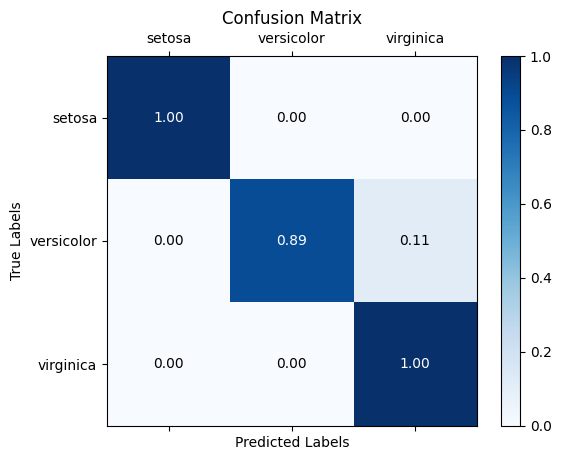

In [9]:
print(f"Test Accuracy: {trainer.eval_accuracy(test_loader)}")
trainer.plot_confusion_matrix(test_loader, class_names=iris.target_names)